<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Overview" data-toc-modified-id="Overview-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Overview</a></span></li></ul></li><li><span><a href="#Load-the-Data" data-toc-modified-id="Load-the-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load the Data</a></span></li><li><span><a href="#Model-the-Data-with-PLS-DA" data-toc-modified-id="Model-the-Data-with-PLS-DA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model the Data with PLS-DA</a></span><ul class="toc-item"><li><span><a href="#Training-a-Hard-Model" data-toc-modified-id="Training-a-Hard-Model-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Training a Hard Model</a></span></li><li><span><a href="#Training-a-Soft-Model" data-toc-modified-id="Training-a-Soft-Model-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Training a Soft Model</a></span></li><li><span><a href="#Testing" data-toc-modified-id="Testing-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Testing</a></span></li></ul></li><li><span><a href="#Optimizing-the-Classifier" data-toc-modified-id="Optimizing-the-Classifier-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Optimizing the Classifier</a></span></li></ul></div>

In [1]:
import matplotlib.pyplot as plt
%matplotlib notebook

import imblearn
import sklearn

from sklearn.model_selection import GridSearchCV

import sys
sys.path.append('../../')
import chemometrics

import numpy as np
import pandas as pd

import watermark
%load_ext watermark

/home/nam/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/nam/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/nam/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 and wil

Overview
--------
This is a simple example of using variants of PLS-DA to do some analysis.

In [2]:
%watermark -t -m -v --iversions

json      2.0.9
sklearn   0.22.2.post1
numpy     1.21.4
imblearn  0.5.0
pandas    0.25.1
watermark 2.0.2
16:19:47 

CPython 3.7.4
IPython 7.8.0

compiler   : GCC 7.3.0
system     : Linux
release    : 4.15.0-163-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit


# Load the Data

In [3]:
# Let's load some data from the tests/ for this example
df = pd.read_csv('../tests/data/plsda3_train.csv')

In [4]:
# You can see that samples are rows, columns are different features
df

,Group,Class,Name,Li,B,Na,Mg,Al,K,Ca,...,Eu,Gd,Dy,Ho,Er,Tm,Yb,Lu,Pb,U
0,1,JPN1,jpn_001,0.001287,0.435363,2.567587,143.601117,0.009235,818.961080,36.075419,...,1.318100e-04,0.000629,0.000041,0.000108,0.000385,0.000182,2.953350e-04,0.000059,0.000182,0.000174
1,1,JPN1,jpn_002,0.001474,0.385210,4.595786,276.591018,0.084693,863.273852,50.704790,...,1.823270e-04,0.000592,0.000386,0.000051,0.000148,0.000021,3.067320e-06,0.000023,0.000443,0.000723
2,1,JPN1,jpn_003,0.000748,0.289601,5.806715,117.037380,0.119564,851.174760,46.020288,...,7.401510e-07,0.000717,0.000353,0.000192,0.000434,0.000194,5.446410e-05,0.000016,0.001359,0.000029
3,1,JPN1,jpn_004,0.000882,0.525801,0.554544,335.195531,0.388480,836.126629,45.437616,...,1.283760e-04,0.000481,0.000124,0.000041,0.000012,0.000180,2.635580e-04,0.000029,0.000948,0.000236
4,1,JPN1,jpn_005,0.001387,0.659031,3.102831,213.051823,0.106865,756.238004,39.155470,...,1.014040e-04,0.000464,0.000608,0.000031,0.000178,0.000102,4.990830e-05,0.000125,0.001060,0.000130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340,1,THA1,tha_372,0.008112,0.515135,3.623354,227.360308,0.075525,830.443160,39.884393,...,1.861820e-04,0.000506,0.000387,0.000062,0.000193,0.000139,7.063200e-07,0.000063,0.001554,0.000056
341,1,THA1,tha_373,0.000198,0.554359,2.752819,397.151899,0.171857,879.746835,45.727848,...,2.826660e-05,0.000265,0.000556,0.000160,0.000157,0.000057,1.746930e-04,0.000183,0.000947,0.000180
342,1,THA1,tha_374,0.006398,0.729045,3.337994,385.826772,0.268925,938.976378,41.141732,...,4.206440e-06,0.000730,0.000662,0.000173,0.000183,0.000141,2.974180e-04,0.000193,0.003334,0.000208
343,1,THA1,tha_375,0.009893,0.457777,3.021736,364.285714,0.144162,978.571429,49.285714,...,1.831960e-04,0.000115,0.000521,0.000150,0.000148,0.000111,2.903890e-04,0.000099,0.000721,0.000079


In [5]:
raw_x = np.array(df.values[:,3:], dtype=float) # Extract features
raw_y = np.array(df['Class'].values, dtype=str) # Take the class as the target

# Model the Data with PLS-DA

In [6]:
from chemometrics.classifier.plsda import PLSDA

## Training a Hard Model

In [7]:
# Here the data are elemental levels so we will scale the X data
plsda = PLSDA(n_components=5, 
              alpha=0.05, 
              gamma=0.01, 
              not_assigned='UNKNOWN', 
              style="hard", 
              scale_x=True)

In [8]:
_ = plsda.fit(raw_x, raw_y)

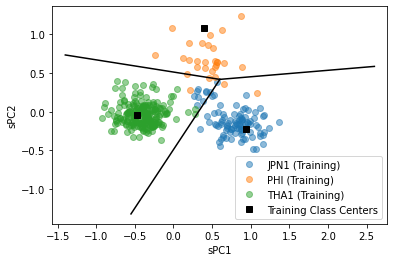

In [10]:
_ = plsda.visualize_2d(styles=['hard'])

In [13]:
# We can see what samples are predicted to be using the predict() function.
pred = plsda.predict(raw_x)

In [15]:
plsda.score(raw_x, raw_y)

0.9565217391304348

In [25]:
# The score() function is just tetsing how many are correctly predicted.  You can do this directly and 
# easily with the "hard" version of PLS-DA.
np.sum(np.array(pred).ravel() == raw_y) / raw_y.shape[0]

0.9565217391304348

In [29]:
# More complete figures of merit can be computed.
df, I, CSNS, CSPS, CEFF, TSNS, TSPS, TEFF = plsda.figures_of_merit(pred, raw_y)

In [30]:
df # Each row is what the sample IS, each column is what the PREDICTION is.

,JPN1,PHI,THA1,UNKNOWN
JPN1,87,0,10,0
PHI,2,24,3,0
THA1,0,0,219,0


In [31]:
I # Total fo each category

JPN1     97
PHI      29
THA1    219
dtype: int64

In [34]:
CSNS

JPN1    0.896907
PHI     0.827586
THA1    1.000000
dtype: float64

In [35]:
CSPS

JPN1    0.991935
PHI     1.000000
THA1    0.896825
dtype: float64

In [36]:
CEFF

JPN1    0.943225
PHI     0.909718
THA1    0.947009
dtype: float64

In [37]:
TSNS, TSPS, TEFF

(0.9565217391304348, 0.9565217391304348, 0.9565217391304348)

## Training a Soft Model

In [38]:
# Here the data are elemental levels so we will scale the X data
plsda = PLSDA(n_components=5, 
              alpha=0.05, 
              gamma=0.01, 
              not_assigned='UNKNOWN', 
              style="soft", 
              scale_x=True)

In [39]:
_ = plsda.fit(raw_x, raw_y)

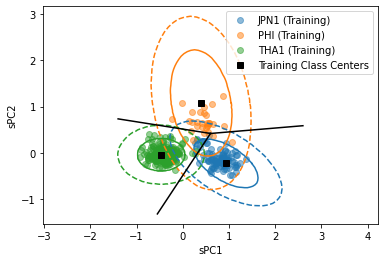

In [41]:
# You can visualize both the hard and soft boundaries if you train a soft model.
# With a hard model, you only get the hard boundaries by default.
_ = plsda.visualize_2d(styles=['hard', 'soft'])

In [44]:
# We can see what samples are predicted to be using the predict() function.
pred = plsda.predict(raw_x)

In [46]:
# Samples can now be predicted to belong to multiple classes.
pred[:10]

[['PHI'],
 ['JPN1', 'PHI'],
 ['PHI', 'JPN1'],
 ['JPN1', 'PHI'],
 ['JPN1', 'PHI'],
 ['PHI'],
 ['PHI'],
 ['PHI', 'JPN1'],
 ['PHI', 'JPN1'],
 ['PHI']]

In [47]:
# More complete figures of merit can be computed.
df, I, CSNS, CSPS, CEFF, TSNS, TSPS, TEFF = plsda.figures_of_merit(pred, raw_y)

In [48]:
df

,JPN1,PHI,THA1,UNKNOWN
JPN1,91,17,0,2
PHI,0,27,0,2
THA1,2,2,203,13


## Testing

First, let's test on other pure samples that weren't in the training set.

In [49]:
df = pd.read_csv('../tests/data/plsda3_test.csv')
raw_x_t = np.array(df.values[:,3:], dtype=float)
raw_y_t = np.array(['THA2']*len(raw_x), dtype=str)

In [50]:
pred = plsda.predict(raw_x_t)
df, I, CSNS, CSPS, CEFF, TSNS, TSPS, TEFF = plsda.figures_of_merit(pred, raw_y_t)

In [51]:
df # Most foreign samples were CORRECTLY identified as being unknown

,JPN1,PHI,THA1,UNKNOWN
THA2,0,0,2,129


# Optimizing the Classifier

Here we took alpha as a meaningful choice of type I error rate, but it could also be adjusted.  Moreover, we arbitrarily selected the number of PCs to use in the PLSDA model.  We can use scikit-learn's pipelines to automatically optimize hyperparameters like this.

In [68]:
# Here I've use an imblearn pipeline, but you can also use scikit-learn's pipeline if you don't want to 
# do any class balancing.

pipeline = imblearn.pipeline.Pipeline(steps=[
    # Insert other preprocessing steps here...
    # ("smote", ScaledSMOTEENN(random_state=1)), # For example, class balancing
    ("plsda", PLSDA(n_components=5, 
                    alpha=0.05,
                    scale_x=True, 
                    not_assigned='UNKNOWN',
                    style='soft', 
                   )
    )
])

# Hyperparameters of pipeline steps are given in standard notation: step__parameter_name
param_grid = [{
    # 'smote__k_enn':[1, 2, 3],
    # 'smote__k_smote':[1, 3, 3],
    # 'smote__kind_sel_enn':['all', 'mode'],
    'plsda__n_components':np.arange(1, 20, 2),
    'plsda__alpha': [0.07, 0.05, 0.03, 0.01],
    #'plsda__scale_x':[True, False],
    #'plsda__style':['hard', 'soft'],
}]

gs = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    n_jobs=-1,
    cv=sklearn.model_selection.StratifiedKFold(n_splits=3, shuffle=True, random_state=0),
    error_score=0,
    refit=True
)

_ = gs.fit(raw_x, raw_y)

In [69]:
# The best parameters found can be accessed like this:
gs.best_params_

{'plsda__alpha': 0.01, 'plsda__n_components': 17}

In [70]:
gs.best_score_ # The best score it recieved was...

0.9446813969750131

In [71]:
# You can see detailed CV results here
gs.cv_results_

{'mean_fit_time': array([0.03112793, 0.0421687 , 0.21751253, 0.19740542, 0.22638766,
        0.30567273, 0.43977269, 0.28914261, 0.69669692, 0.57967488,
        0.11097296, 0.13863158, 0.15809178, 0.24364058, 0.31838799,
        0.3027757 , 0.26194708, 0.52958894, 0.45093656, 0.51302306,
        0.09555054, 0.10808786, 0.14111757, 0.34709787, 0.22556941,
        0.34662294, 0.29701487, 0.39607461, 0.27603086, 0.45788447,
        0.07818254, 0.09091751, 0.20977012, 0.31567589, 0.21590082,
        0.31762942, 0.38640221, 0.33978105, 0.3923893 , 0.30695661]),
 'std_fit_time': array([0.0250123 , 0.02377157, 0.10387651, 0.01704162, 0.09617969,
        0.06245745, 0.20130332, 0.07511074, 0.2371326 , 0.10506917,
        0.0351331 , 0.03120406, 0.0370441 , 0.03583325, 0.07648771,
        0.06919303, 0.06939128, 0.34377202, 0.01053736, 0.09616427,
        0.02940842, 0.02757111, 0.06230777, 0.01055465, 0.06426243,
        0.0647017 , 0.09654324, 0.06456925, 0.03682501, 0.03676745,
        0.037

In [72]:
# For a 1D optimization you can easily visualize where the best value is:
# plt.errorbar(np.arange(1, 20, 2), gs.cv_results_['mean_test_score'], yerr=gs.cv_results_['std_test_score'])
# plt.xlabel('n_components')
# plt.ylabel('Mean Test Score (TEFF)')

In [ ]:
# scikit-learn finds the optimum over the range, however, you may wish to simply look at these results
# and use a smaller value, perhaps at an "elbow", and re-train a new model separately.

In [73]:
# The refit=True (default) refits the model on the data in the end so you can use it directly.
gs.best_estimator_.predict(raw_x)

[['JPN1', 'PHI'],
 ['JPN1', 'PHI'],
 ['JPN1', 'PHI'],
 ['JPN1', 'PHI'],
 ['JPN1', 'PHI'],
 ['PHI', 'JPN1'],
 ['JPN1', 'PHI'],
 ['JPN1', 'PHI'],
 ['JPN1', 'PHI'],
 ['JPN1', 'PHI'],
 ['JPN1', 'PHI'],
 ['PHI', 'JPN1'],
 ['JPN1'],
 ['JPN1', 'PHI'],
 ['JPN1', 'PHI'],
 ['JPN1'],
 ['JPN1'],
 ['JPN1'],
 ['JPN1'],
 ['JPN1'],
 ['JPN1'],
 ['JPN1'],
 ['JPN1'],
 ['JPN1'],
 ['JPN1'],
 ['JPN1'],
 ['JPN1', 'PHI'],
 ['JPN1'],
 ['JPN1'],
 ['JPN1'],
 ['JPN1'],
 ['JPN1'],
 ['JPN1'],
 ['JPN1'],
 ['JPN1'],
 ['JPN1'],
 ['JPN1'],
 ['JPN1'],
 ['JPN1'],
 ['JPN1', 'PHI'],
 ['JPN1', 'PHI'],
 ['JPN1'],
 ['JPN1'],
 ['JPN1'],
 ['JPN1'],
 ['JPN1'],
 ['JPN1'],
 ['JPN1'],
 ['JPN1'],
 ['JPN1'],
 ['JPN1'],
 ['JPN1'],
 ['JPN1'],
 ['JPN1', 'PHI'],
 ['JPN1', 'PHI'],
 ['PHI'],
 ['JPN1'],
 ['JPN1'],
 ['JPN1'],
 ['JPN1'],
 ['JPN1'],
 ['JPN1'],
 ['JPN1', 'PHI'],
 ['JPN1'],
 ['JPN1'],
 ['JPN1'],
 ['JPN1'],
 ['JPN1'],
 ['JPN1'],
 ['JPN1'],
 ['JPN1'],
 ['JPN1'],
 ['JPN1'],
 ['JPN1'],
 ['JPN1'],
 ['JPN1'],
 ['JPN1'],
 ['JPN1', 'PHI

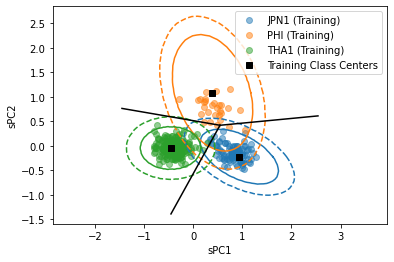

In [74]:
# You can visualize the training results
gs.best_estimator_.named_steps['plsda'].visualize_2d(styles=['hard', 'soft'])

In [75]:
# Train 
gs.best_estimator_.named_steps['plsda'].score(raw_x, raw_y) # The score being used here is TEFF

0.9485836621422361

In [77]:
pred = gs.best_estimator_.named_steps['plsda'].predict(raw_x)
df, I, CSNS, CSPS, CEFF, TSNS, TSPS, TEFF = plsda.figures_of_merit(pred, raw_y)

In [87]:
pred[:20]

[['JPN1', 'PHI'],
 ['JPN1', 'PHI'],
 ['JPN1', 'PHI'],
 ['JPN1', 'PHI'],
 ['JPN1', 'PHI'],
 ['PHI', 'JPN1'],
 ['JPN1', 'PHI'],
 ['JPN1', 'PHI'],
 ['JPN1', 'PHI'],
 ['JPN1', 'PHI'],
 ['JPN1', 'PHI'],
 ['PHI', 'JPN1'],
 ['JPN1'],
 ['JPN1', 'PHI'],
 ['JPN1', 'PHI'],
 ['JPN1'],
 ['JPN1'],
 ['JPN1'],
 ['JPN1'],
 ['JPN1']]

In [78]:
df

,JPN1,PHI,THA1,UNKNOWN
JPN1,96,26,0,0
PHI,0,29,0,0
THA1,2,2,215,1


In [79]:
CSNS

JPN1    0.989691
PHI     1.000000
THA1    0.981735
dtype: float64

In [80]:
CSPS

JPN1    0.991935
PHI     0.911392
THA1    1.000000
dtype: float64

In [81]:
CEFF

JPN1    0.990812
PHI     0.954669
THA1    0.990825
dtype: float64

In [82]:
TSPS, TSNS, TEFF

(0.9130434782608696, 0.9855072463768116, 0.9485836621422361)

In [85]:
np.any(gs.best_estimator_.named_steps['plsda'].check_outliers())

False

In [89]:
# Test
gs.best_estimator_.named_steps['plsda'].score(raw_x_t, raw_y_t) # The score being used here is TEFF

0.9884057971014493

In [90]:
pred = gs.best_estimator_.named_steps['plsda'].predict(raw_x_t)
df, I, CSNS, CSPS, CEFF, TSNS, TSPS, TEFF = plsda.figures_of_merit(pred, raw_y_t)

In [92]:
pred[:20]

[['UNKNOWN'],
 ['THA1'],
 ['THA1'],
 ['UNKNOWN'],
 ['UNKNOWN'],
 ['UNKNOWN'],
 ['UNKNOWN'],
 ['UNKNOWN'],
 ['UNKNOWN'],
 ['UNKNOWN'],
 ['UNKNOWN'],
 ['UNKNOWN'],
 ['UNKNOWN'],
 ['UNKNOWN'],
 ['UNKNOWN'],
 ['UNKNOWN'],
 ['UNKNOWN'],
 ['UNKNOWN'],
 ['UNKNOWN'],
 ['UNKNOWN']]

In [93]:
df

,JPN1,PHI,THA1,UNKNOWN
THA2,0,0,4,127
